# 4. 뉴스 요약봇 만들기

## Step 1. 데이터 수집하기


In [416]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas

print(nltk.__version__)
print(tensorflow.__version__)
print(pandas.__version__)
print(version('summa'))

3.8.1
2.14.0
2.1.3
1.2.0


In [417]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

=3


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/centillion/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [418]:
import urllib.request
import pandas as pd
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [419]:
data.sample(10)

,headlines,text
93025,FIR ordered against woman cop for sexually ass...,A Delhi court has ordered an FIR against a pol...
56603,"BJP leader posts picture with AK-47, captions ...",Youth Bharatiya Janata Party leader Ashish Sar...
8937,Mumbai-based wealth management startup CashRic...,Mumbai-based wealth management startup CashRic...
35997,Monthly salary of L-Gs more than doubled to Ã¢...,The Union Cabinet has approved a proposal to r...
71329,Bihar journalist Pankaj Mishra shot at by two men,Rashtriya Sahara journalist Pankaj Mishra was ...
30331,Anxious SRK stayed awake 24 hrs for KKR's do-o...,Kolkata Knight Riders' owner Shah Rukh Khan tw...
5714,Malaysia charges US bank Goldman Sachs over 1M...,Malaysia has filed criminal charges against Go...
75926,Jacqueline shares pic from Tokyo vacation on h...,Actress Jacqueline Fernandez took to social me...
34127,"Reliance adds Ã¢ÂÂ¹22,000 crore in a day as J...",Mukesh Ambani-led Reliance Industries (RIL) ad...
74528,Google adds 6-second preview for videos to mob...,Search giant Google on Saturday added a six-se...


In [420]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


## Step 2. 데이터 전처리하기 (추상적 요약)


### 중복 샘플과 NULL 값이 존재하는 샘플 제거

중복 샘플 유무를 확인

In [421]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280



데이터프레임의 ```drop_duplicates()```를 사용하면, 손쉽게 중복 샘플을 제거

In [422]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


데이터프레임에 Null 값이 있는지 확인

In [423]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### 텍스트 정규화와 불용어 제거



In [424]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


불용어 리스트

In [425]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

데이터 전처리 함수
- html 태그 제거
- ()로 닫힌 문자열 제거
- " 제거
- 약어 정규화
- 소유격 제거
- 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
- m이 3개 이상 -> 2개로 변경
- 불용어 제거(remove_stopwords = True이면)


In [426]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    #sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = BeautifulSoup(sentence, "html.parser").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


text 전처리 실행

In [427]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
clean_text = []

for i, text in enumerate(data['text']):
    # if i % 5000 == 0:
    #     print(i)
    clean_text.append(preprocess_sentence(text))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

headlines 전처리 실행

In [428]:
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
clean_headlines = []

for text in data['headlines']:
    clean_headlines.append(preprocess_sentence(text, False))

print("Summary 전처리 후 결과: ", clean_headlines[:5])

/tmp/ipykernel_1889365/2986640144.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "html.parser").text # <br />, <a href = ...> 등의 html 태그 제거


Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


다시 한번 빈(empty) 샘플이 생겼는지 확인
- 없으므로 ''인 라인을 지울 필요 없음

In [429]:
print(clean_text.count(''))
print(clean_headlines.count(''))

print("전체 샘플수: ", len(data))


0
0
전체 샘플수:  98360


### 데이터 전처리하기 (2) 훈련데이터와 테스트데이터 나누기


#### 샘플의 최대 길이 정하기


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.23813542090281
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 18
헤드라인의 평균 길이 : 9.553660024400163


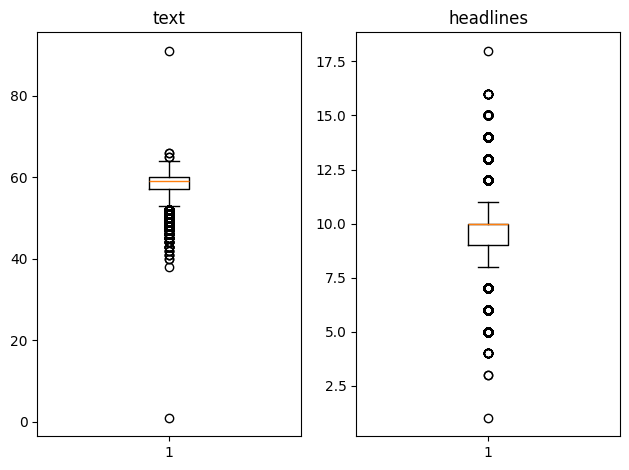

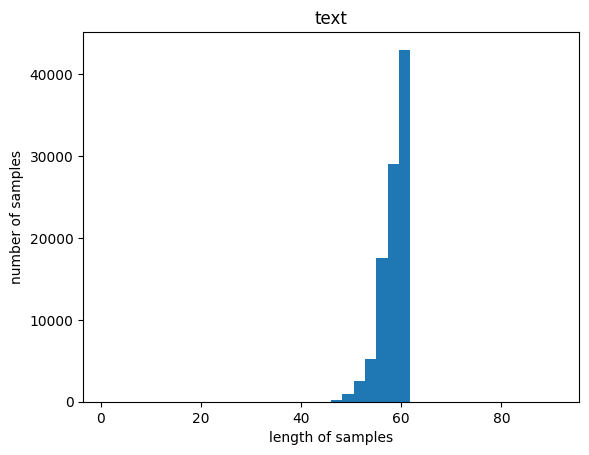

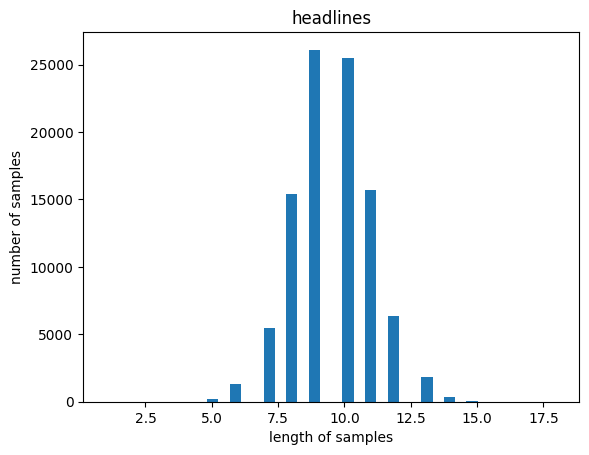

In [430]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

1 단어로 된 text, headline이 존재하여 확인해 봤더니 ('headlines', 'text') 레코드가 존재하여 삭제하였다.

In [431]:
for i, s in enumerate(data['text']):
    if len(s.split()) < 5:
        print(i, data.loc[i, "headlines"], data.loc[i, "text"])

print(data.iloc[50:54])
data = data.drop(52, axis = 0)
print(data.iloc[50:54])

52 headlines text
                                            headlines  \
50  Yashwant Sinha demands probe into alleged fund...   
51  Boeing sales cross $100bn for 1st time in its ...   
52                                          headlines   
53  OnePlus named bestselling premium smartphone b...   

                                                 text  
50  Former Finance Minister Yashwant Sinha on Tues...  
51  US-based Boeing on Wednesday reported annual s...  
52                                               text  
53  OnePlus has emerged as India's best-selling pr...  
                                            headlines  \
50  Yashwant Sinha demands probe into alleged fund...   
51  Boeing sales cross $100bn for 1st time in its ...   
53  OnePlus named bestselling premium smartphone b...   
54  Can never look at female body, even if naked, ...   

                                                 text  
50  Former Finance Minister Yashwant Sinha on Tues...  
51  US-based Boein

In [432]:
text_max_len = 60
headlines_max_len = 12
print('=3')

=3


데이터의 몇 %가 해당하는지 계산하는 함수

In [433]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [434]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.9974481237100824
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.976819609796765


정해진 길이보다 길면 제외하는 방법으로 데이터를 정제


In [435]:
# data = data[data.apply(lambda x: len(x['Text'].split()) <= text_max_len 
#     & data.apply(lambda x: len(x['Summary'].split())) <= summary_max_len)]
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len) & 
            data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

print('전체 샘플수 :', (len(data)))
data.head()

전체 샘플수 : 95837


,headlines,text
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...
7,Govt directs Alok Verma to join work 1 day bef...,Weeks after ex-CBI Director Alok Verma told th...


#### 디코더 인풋/타겟에 시작 토큰과 종료 토큰 추가하기


In [436]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,sostoken Delhi techie wins free food from Swig...,Delhi techie wins free food from Swiggy for on...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,sostoken New Zealand end Rohit Sharma-led Indi...,New Zealand end Rohit Sharma-led India's 12-ma...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",sostoken Aegon life iTerm insurance plan helps...,Aegon life iTerm insurance plan helps customer...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...,sostoken Rahat Fateh Ali Khan denies getting n...,Rahat Fateh Ali Khan denies getting notice for...
7,Govt directs Alok Verma to join work 1 day bef...,Weeks after ex-CBI Director Alok Verma told th...,sostoken Govt directs Alok Verma to join work ...,Govt directs Alok Verma to join work 1 day bef...


디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

In [437]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


훈련 데이터와 테스트 데이터를 분리

In [438]:
encoder_input.shape

(95837,)

In [439]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[60887 43120 93332 ... 80530 92342 60169]


In [440]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리

In [441]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19167


In [442]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 76670
훈련 레이블의 개수 : 76670
테스트 데이터의 개수 : 19167
테스트 레이블의 개수 : 19167


### 데이터 전처리하기 (3) 정수 인코딩

#### 단어 집합(vocabulary) 만들기 및 정수 인코딩


In [443]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인

```src_tokenizer.word_counts.items()```에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻을 수 있다.

In [444]:
threshold = 8
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 90442
등장 빈도가 7번 이하인 희귀 단어의 수: 67797
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22645
단어 집합에서 희귀 단어의 비율: 74.96185400588222
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.0638089159283073


등장 빈도가 threshold 값인 8회 미만, 즉 7회 이하인 단어들은 단어 집합에서 74% 이상을 차지한다. 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 3.05%밖에 되지 않는다.

그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 한다. 단어 집합의 크기를 22000개로 제한한다. 

In [445]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 22,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


```texts_to_sequences()```는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행한다. 단어 집합의 크기를 22,000으로 제한했으므로 22,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않는다.

In [446]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[9, 1, 48, 77, 177, 37, 9204, 4059, 8, 38, 312, 1, 41, 48, 2519, 7, 37, 519, 5, 360, 287, 192, 2600, 161, 1, 519, 12, 3143, 15, 1002, 3948, 5518, 5669, 9, 1, 4785, 77, 21, 878, 756, 72, 146, 4368, 136, 28, 8, 290, 1, 48, 41, 48, 416, 2, 25, 312, 4, 1, 519], [911, 149, 2358, 3037, 4836, 7, 123, 1276, 15939, 19, 95, 1423, 28, 34, 1239, 94, 7, 1, 642, 2, 734, 6947, 149, 4836, 12, 7, 17, 402, 2, 1, 71, 385, 70, 14, 983, 1, 1423, 6, 303, 224, 19, 17, 273, 2, 2507, 15939, 14, 10, 219, 3, 472, 1567, 177, 183, 1, 95, 1423, 23, 25, 4305], [130, 7, 134, 132, 40, 2, 1564, 1, 4222, 5, 8780, 234, 4, 170, 29, 3, 97, 896, 830, 157, 25, 7476, 6, 25, 1942, 16, 3, 3781, 333, 820, 479, 486, 791, 8, 68, 10, 1, 8780, 234, 12, 3, 1440, 5, 820, 7379, 387, 6, 157, 25, 1310, 36, 2, 130]]


headlines 데이터에 대해서도 동일한 작업을 수행

In [447]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


target token의 통계 정보를 얻어서 등장 빈도수가 7회 미만인 단어들의 데이터 내 비중을 확인한다.
- ```tar_tokenizer.word_counts.items()```에 단어와 각 단어의 등장 빈도수가 저장되어 있다.

In [448]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 40438
등장 빈도가 5번 이하인 희귀 단어의 수: 29269
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11169
단어 집합에서 희귀 단어의 비율: 72.37993966071517
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.308998739658699


등장 빈도가 2회 이하인 단어들은 단어 집합에서 약 57%를 차지한다. 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은  3.46%밖에 되지 않는다. 이 단어들은 모두 제거하고. 단어 집합의 크기를 17000개로 제한한다.
- headline의 특성상 등장 빈도가 낮은 단어가 아마존 예에서 보다 적다.
- target 단어수가 많아지면 어떤 영향이 있을까?

In [449]:
#tar_vocab = 10000
#tar_vocab = 5000
#tar_vocab = 2000
#tar_vocab = 1000
#tar_vocab = 500
tar_vocab = 11000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 15, 44, 1843, 21, 7, 2780, 2346, 103, 442, 5, 47, 60], [1, 453, 39, 837, 13, 3008, 121, 742], [1, 2268, 9339, 6, 4841, 211, 4, 58, 65, 3, 14], [1, 602, 928, 2781, 3, 273, 97, 6409, 671, 5, 131, 5192], [1, 2347, 71, 4113, 181, 644, 1010]]
target
decoder  [[15, 44, 1843, 21, 7, 2780, 2346, 103, 442, 5, 47, 60, 2], [453, 39, 837, 13, 3008, 121, 742, 2], [2268, 9339, 6, 4841, 211, 4, 58, 65, 3, 14, 2], [602, 928, 2781, 3, 273, 97, 6409, 671, 5, 131, 5192, 2], [2347, 71, 4113, 181, 644, 1010, 2]]


요약문에서 길이가 0이 된 샘플들의 데이터를 지운다.
- decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태
- 길이가 0이 된 요약문의 실제 길이는 1로 나온다.
- 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test 변수에 저장하고 이 샘플들은 모두 삭제할 거예요.

In [450]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 76670
훈련 레이블의 개수 : 76670
테스트 데이터의 개수 : 19167
테스트 레이블의 개수 : 19167


#### 패딩하기

서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업 시행

In [451]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


## Step 3. 모델 설계하기

### 인코더

In [452]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# recurrent drop out
#recurrent_dropout_flag = True
recurrent_dropout_flag = False

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
if recurrent_dropout_flag:
    encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
else:
    encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
if recurrent_dropout_flag:
    encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
else:
    encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
if recurrent_dropout_flag:
    encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
else:
    encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)


### 디코더

In [453]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
if recurrent_dropout_flag:
    decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
else:
    decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더의 출력층에서는 Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 한다. 그러므로, Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용한다.


### 어텐션 메커니즘



In [454]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_33 (InputLayer)       [(None, 60)]                 0         []                            
                                                                                                  
 embedding_14 (Embedding)    (None, 60, 128)              2816000   ['input_33[0][0]']            
                                                                                                  
 lstm_28 (LSTM)              [(None, 60, 256),            394240    ['embedding_14[0][0]']        
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                           

위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있어요.

### 모델 훈련하기

설계한 모델을 가지고 훈련 진행

In [455]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50


2023-11-15 15:29:45.905337: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 2080 Ti" frequency: 1650 num_cores: 68 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11080" } environment { key: "cudnn" value: "8600" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 5767168 shared_memory_size_per_multiprocessor: 65536 memory_size: 9511632896 bandwidth: 616000000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


300/300 [==============================] - ETA: 0s - loss: 6.1401

2023-11-15 15:30:04.532652: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 2080 Ti" frequency: 1650 num_cores: 68 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11080" } environment { key: "cudnn" value: "8600" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 5767168 shared_memory_size_per_multiprocessor: 65536 memory_size: 9511632896 bandwidth: 616000000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


300/300 [==============================] - 23s 66ms/step - loss: 6.1401 - val_loss: 5.7992
Epoch 2/50
300/300 [==============================] - 17s 57ms/step - loss: 5.8249 - val_loss: 5.7149
Epoch 3/50
300/300 [==============================] - 17s 57ms/step - loss: 5.7279 - val_loss: 5.6232
Epoch 4/50
300/300 [==============================] - 17s 56ms/step - loss: 5.6339 - val_loss: 5.5157
Epoch 5/50
300/300 [==============================] - 17s 56ms/step - loss: 5.5026 - val_loss: 5.4040
Epoch 6/50
300/300 [==============================] - 17s 56ms/step - loss: 5.3786 - val_loss: 5.2718
Epoch 7/50
300/300 [==============================] - 17s 56ms/step - loss: 5.2497 - val_loss: 5.1722
Epoch 8/50
300/300 [==============================] - 17s 56ms/step - loss: 5.1326 - val_loss: 5.0645
Epoch 9/50
300/300 [==============================] - 17s 56ms/step - loss: 5.0215 - val_loss: 4.9781
Epoch 10/50
300/300 [==============================] - 17s 56ms/step - loss: 4.9135 - val_los

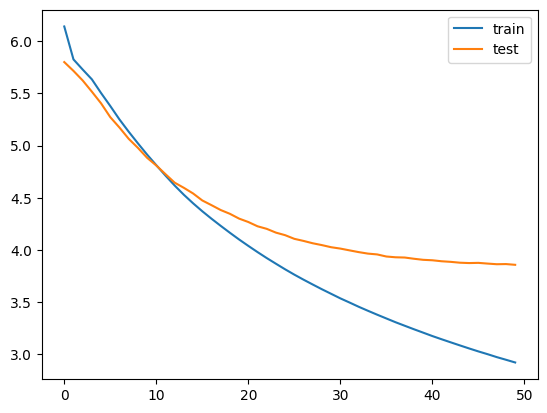

In [456]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Step 4. 실제 결과와 요약문 비교하기(추상적 요약)

테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 만든다.

In [457]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다. 
정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 한다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계한다.

In [458]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


어텐션 메커니즘을 사용하는 출력층을 설계

In [459]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

In [460]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    i = 0
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복
        # i += 1
        # if i == 1:
        #     print(target_seq.shape)
        #     print(e_out.shape, e_h.shape, e_c.shape)    
            
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c], verbose = 0)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


###  모델 테스트하기

In [461]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i != 0 and i != tar_word_to_index['sostoken']) and i != tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교함

In [462]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : ministers are taking leadership lessons at the indian institute of management ahmedabad to deliver on their pre poll promises the ministers who were on a three day study tour that started on monday have taken lessons on leadership and ethics healthcare education and public private partnership the bjp government came to power in jharkhand two and a half years ago 
실제 요약 : jharkhand ministers take management lessons at iim a 


1/1 [==============================] - 0s 494ms/step


2023-11-15 15:43:53.867347: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 2080 Ti" frequency: 1650 num_cores: 68 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11080" } environment { key: "cudnn" value: "8600" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 5767168 shared_memory_size_per_multiprocessor: 65536 memory_size: 9511632896 bandwidth: 616000000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


예측 요약 :  punjab govt to get special for 3 days in parliament


원문 : irish tech startup has rolled out a plan to produce a imaging system that can identify cows from their facial features and hide patterns the artificial intelligence ai system will use face recognition to track the behaviour eating patterns and overall health of livestock it will then send instant alerts to farmers helping them take on farm decisions nnnn 
실제 요약 : irish startup to develop facial recognition system for cows 
1/1 [==============================] - 0s 22ms/step
예측 요약 :  startup bans meat recognition to monitor people in us


원문 : speaking during the lok sabha debate over the rafale deal defence minister nirmala sitharaman has said there is a difference between defence dealings and dealing in defence we deal in defence with national security as a priority congress failed to bring even a single aircraft during upa's tenure all 36 fighter jets will come to india by 2022 sitharaman added 
실제 요약 : difference in

### 모델 서머리

In [463]:
decoder_model.summary()

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_34 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embedding_15 (Embedding)    (None, None, 128)            1408000   ['input_34[0][0]']            
                                                                                                  
 input_35 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 input_36 (InputLayer)       [(None, 256)]                0         []                            
                                                                                           

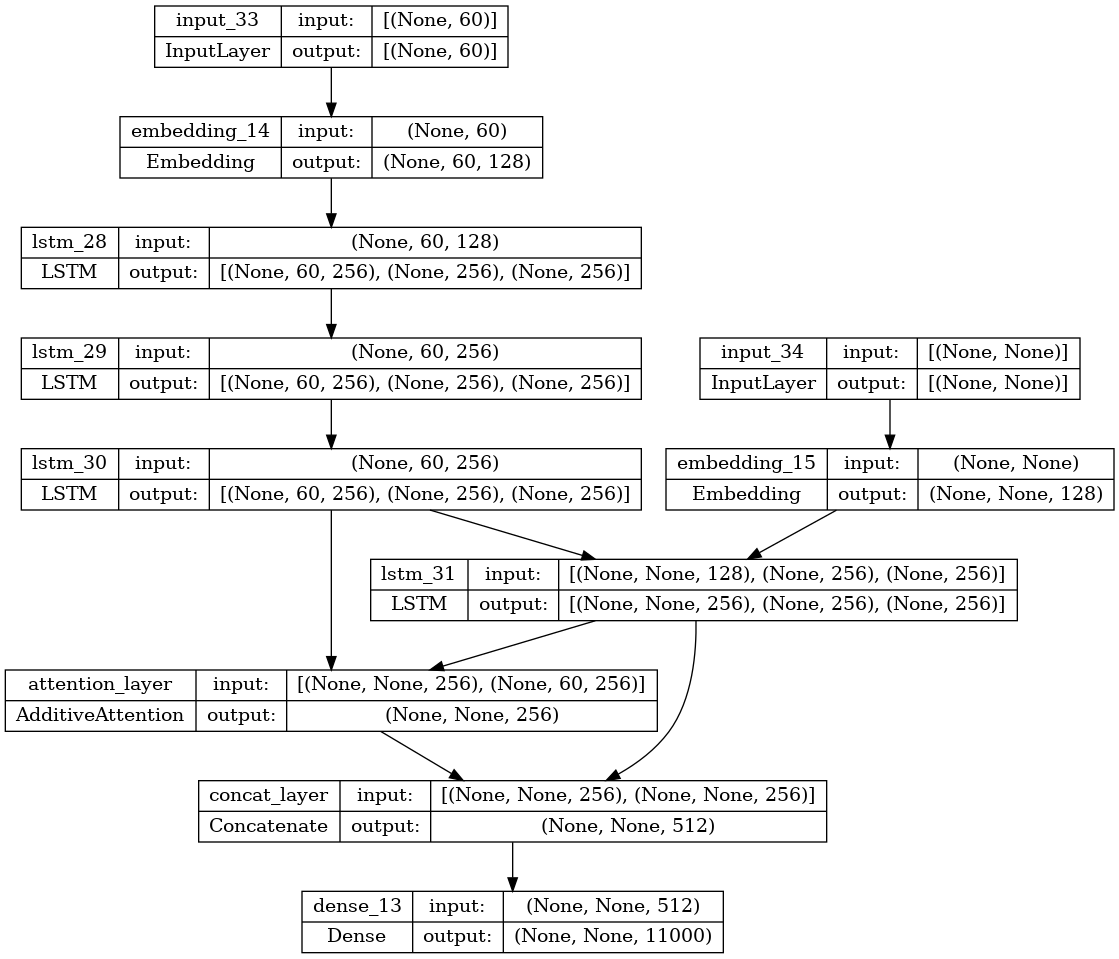

In [464]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

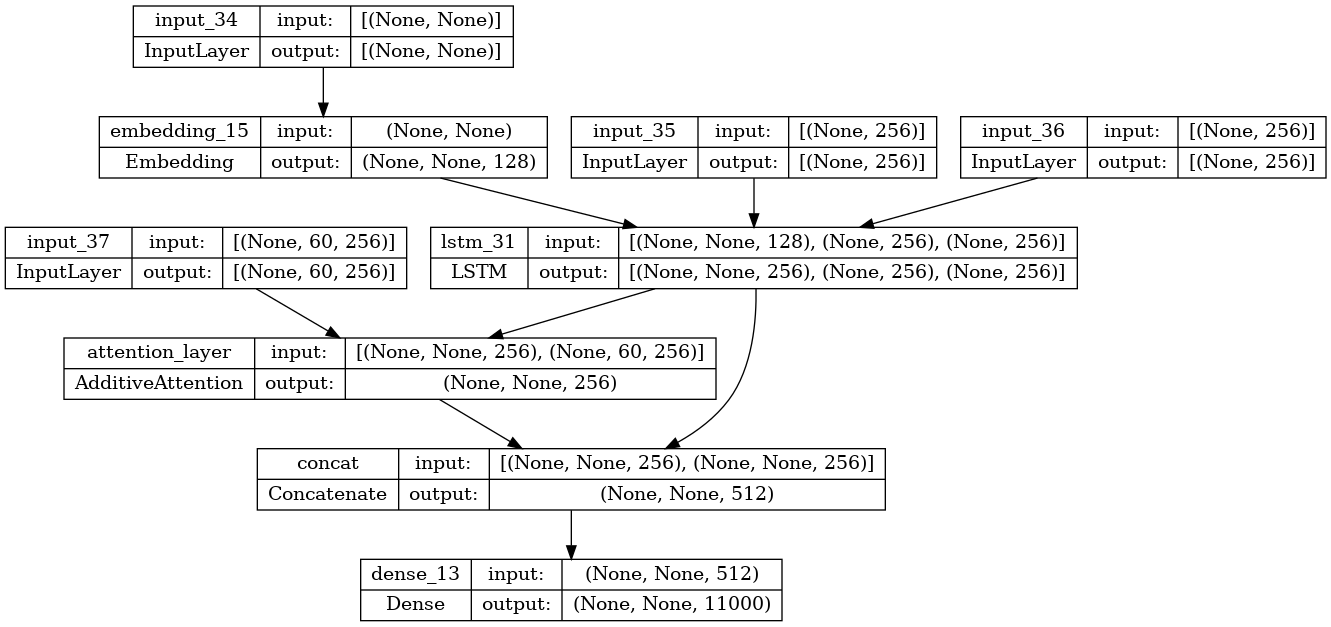

In [465]:
import tensorflow as tf
tf.keras.utils.plot_model(decoder_model, show_shapes=True, show_layer_names=True)

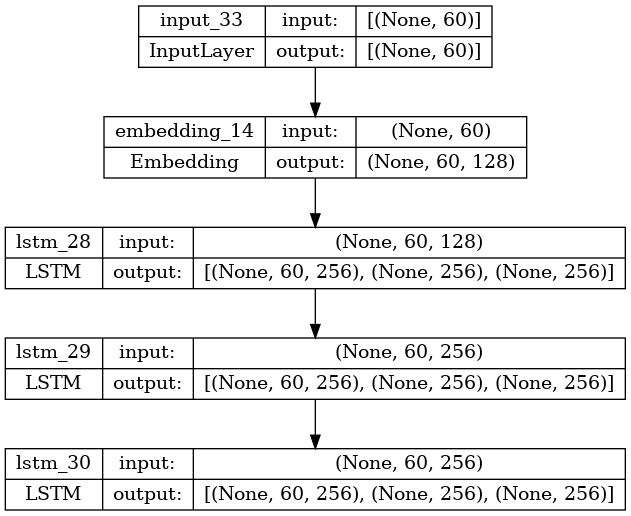

In [466]:
tf.keras.utils.plot_model(encoder_model, show_shapes=True, show_layer_names=True)

```
원문 : actor irrfan khan while talking about his equation with his son said we are open about relationships there's no hesitation or embarrassment discussing with him any kind of relationship even if it's sexual there should be a space where you can discuss he added irrfan further said it is better to have a friendly relationship with your children 
실제 요약 : no sexual with son 
1/1 [==============================] - 0s 18ms/step
예측 요약 :  no one of on


원문 : a communist a pie in french philosopher bernard face while he was promoting his film ' which is about kurds fighting isis in serbia on wednesday levy once scrutinised for backing military intervention in libya has been attacked with nine times by the same man meanwhile another protester held a banner saying bernard levy advocates murders 
실제 요약 : french hit with in face for time 
1/1 [==============================] - 0s 15ms/step
예측 요약 :  video shows in


원문 : german chancellor angela chief of staff peter on saturday said german must invest more in electric vehicles and take on elon musk's tesla when is our automobile industry which is so good actually going to be in a position to build a car that travels 50 kilometres further than a tesla and costs ã¢ââ¬10 000 less said 
실제 요약 : must take on tesla 
1/1 [==============================] - 0s 16ms/step
예측 요약 :  tesla on tesla


원문 : rebel congress leader shehzad poonawalla has released facebook data leak accused firm cambridge analytica's proposal to the party to prepare for 2019 lok sabha elections the 49 page report titled driven campaign the path to the 2019 lok was allegedly developed in august 2017 the proposal said whenever somebody registered on the website their details were recorded to target ads 
실제 요약 : cong leader fb 2019 to cong 
1/1 [==============================] - 0s 16ms/step
예측 요약 :  fb to in polls


원문 : as many as 19 people were killed after a truck laden with cement overturned on the ahmedabad highway in gujarat on saturday morning at least seven people were also reported to be injured in the accident the injured people were immediately rushed to a nearby hospital reports said 
실제 요약 : 19 as on in gujarat 
1/1 [==============================] - 0s 15ms/step
예측 요약 :  12 killed in in


원문 : his government runs on the values of the constitution maharashtra cm devendra fadnavis on thursday said the constitution shows us the way in a better manner than the gita bible and quran as to how to serve people he said the indian constitution is the best constitution in the world and is more important for us than any religious book 
실제 요약 : more for govt than maha cm 
1/1 [==============================] - 0s 15ms/step
예측 요약 :  india has a in the cm


원문 : survey satellite known as tess has spotted hot earth and super earth planets in solar systems 49 and 60 light years away marking its first discovery since april launch tess is designed to build on the work of its predecessor kepler space telescope which discovered over 2 500 confirmed exoplanets in 20 years and is now running out of fuel 
실제 요약 : nasa 2 new 5 months after launch 
1/1 [==============================] - 0s 19ms/step
예측 요약 :  new of the first time


원문 : the uidai on saturday denied media reports which claimed that anyone can access personal details of all aadhaar holders due to an unsecured interface operated by a state owned utility company for verifying customers' identities there is no truth in this story as there has been absolutely no breach of aadhaar database the uidai said 
실제 요약 : denies reports on aadhaar govt firm 
1/1 [==============================] - 0s 17ms/step
예측 요약 :  denies of aadhaar


원문 : japanese carmaker nissan has asked its staff to avoid contact with ousted chairman carlos ghosn and former director greg kelly they are currently facing probe for allegedly under reporting compensation by 80 million in 2011 2018 the automaker also directed staff to report any attempted contact to the company's legal department 
실제 요약 : asks staff to not 
1/1 [==============================] - 0s 17ms/step
예측 요약 :  to over


원문 : gurugram based second hand automobile startup has raised around crore 30 million in series e round of funding the round was led by the family office of japanese based investor joe who is the founder of multi business firm along with an undisclosed foreign investor founded in 2014 provides an online marketplace for sale of new and used automobiles 
실제 요약 : startup raises crore 
1/1 [==============================] - 0s 19ms/step
예측 요약 :  startup raises crore from


원문 : of united nations un employees have been sexually harassed at work in the past two years according to the findings of the first survey on such misconduct out of the 30 respondents 10 1 said that they were touched in ways that made them feel uncomfortable only one in three people said that they took action after experiencing sexual harassment 
실제 요약 : 1 in 3 un in two years 
1/1 [==============================] - 0s 18ms/step
예측 요약 :  in in


원문 : recalling the australian cricket teams he faced in his career indian cricketer harbhajan singh said this team is not a shadow of that australian side t he australian side that i competed against the top seven or eight were all match winners anyone could come in and win a match in his own right harbhajan added 
실제 요약 : australia not a of team i 
1/1 [==============================] - 0s 17ms/step
예측 요약 :  team india team team


원문 : has lost a uk lawsuit filed by indian banks seeking to collect over 1 55 billion amid allegations that he committed massive fraud the court said lenders can enforce an indian court ruling related to allegations that mallya defaulted on 1 4 billion in debt for his now defunct kingfisher airlines it refused to overturn worldwide order freezing mallya's assets 
실제 요약 : loses uk by indian to 1 bn 
1/1 [==============================] - 0s 16ms/step
예측 요약 :  uk to pay 1 bn over


원문 : reacting to preity bidding during the first day of the ipl auction a user tweeted can the other teams get any player other tweets read auctioneer next player for auction is preity zinta 3 crore auctioneer ma'am player ka naam toh do and mom beta ye lo chocolate zinta 
실제 요약 : can get tweets user on ipl 
1/1 [==============================] - 0s 16ms/step
예측 요약 :  tweets user on ipl


원문 : salman khan rekha shatrughan sinha and his daughter sonakshi sinha have featured in a remake of the song which is in the form of a for the dharmendra starrer 'yamla pagla deewana phir se' the also featured other old songs including mere sona re sona e ishq meri jaan' and 'main jat 
실제 요약 : salman in 
1/1 [==============================] - 0s 17ms/step
예측 요약 :  salman khan for


원문 : the cbi on thursday arrested rotomac owner vikram kothari and his son rahul for allegedly defrauding banks of ã¢ââ¹3 700 crore company had submitted forged documents to get loans and created shell firms to carry out illegal activities earlier authorities had notified all land sea and air ports to prevent kothari and his family members from leaving india 
실제 요약 : cbi in 
1/1 [==============================] - 0s 16ms/step
예측 요약 :  delhi son crore for


원문 : tibetan spiritual leader dalai lama has said that indians are than the chinese partly attributing their to the climate he further said that india was the most stable and living example of how people of diverse traditions and ideas could live together the spiritual leader also called on india and china to solve their issues through dialogue 
실제 요약 : indians are than the chinese 
1/1 [==============================] - 0s 15ms/step
예측 요약 :  india for india


원문 : scientists have discovered the oldest known colours 1 1 billion year old bright pink extracted from rocks beneath africa's sahara desert the are fossils of produced by organisms which inhabited an ancient ocean said a researcher from australian national university the fossils range from blood red to deep purple in form and bright pink when diluted 
실제 요약 : as world's 
1/1 [==============================] - 0s 16ms/step
예측 요약 :  scientists 1 1 billion


원문 : the wealth of india's richest person mukesh ambani can keep the country's government running for 20 days according to bloomberg the chairman of india's second most valuable company reliance industries ambani has a net worth of around 40 billion born on april 19 1957 the business tycoon celebrates his 61st birthday today 
실제 요약 : could india's govt for 20 days 
1/1 [==============================] - 0s 15ms/step
예측 요약 :  why do the india's


원문 : baba ramdev led patanjali ayurved has said that it has no plans for an initial public offer ipo yet in an interview patanjali md acharya balkrishna has said the company is focussing only on the domestic market currently and not looking at the international market with he further said ads are not for promoting our products but are ã¢ââ 
실제 요약 : has no plans for an 
1/1 [==============================] - 0s 15ms/step
예측 요약 :  no to


원문 : a video has surfaced wherein congress mla and madhya pradesh labour minister mahendra singh could be heard saying workers and officers who won't follow instructions kar diya will be kicked out the minister made the remark while interacting with party workers in the state's district on december 31 
실제 요약 : mp on not orders 
1/1 [==============================] - 0s 15ms/step
예측 요약 :  will be if bjp mla


원문 : wishing her husband dharmendra deol on his birthday on saturday hema malini tweeted happy birthday to my love the dearest father to my darling girls and proud grandfather to and i thank all the numerous fans who are sending their greetings to me on birthday will definitely convey their wishes to him she further wrote n 
실제 요약 : to my 
1/1 [==============================] - 0s 15ms/step
예측 요약 :  my on my


원문 : khan has said that for most part of her life she was completely non famous my only identity was i was a sibling or a daughter to these other famous people you're recognised but people don't know your name added soha she further said that she doesn't get upset by this as it has become a part of her identity 
실제 요약 : for most of my life i was 
1/1 [==============================] - 0s 15ms/step
예측 요약 :  i'm my life for me


원문 : the government has clarified that resolution plans under insolvency and bankruptcy code ibc do not require the approval of the shareholders the resolution process is taken up after it is approved by the authority which is the national company law tribunal the clarification reportedly comes amid concerns about the possibility of companies' promoters blocking resolution process 
실제 요약 : not for govt 
1/1 [==============================] - 0s 15ms/step
예측 요약 :  govt not not to govt


원문 : former italian prime minister on monday described french president emmanuel macron as a 39 year old lad with a with a good looking mum in an apparent dig at the age gap between macron and his wife brigitte notably aged 80 is 49 years older than his partner 
실제 요약 : is yr old with ex pm 
1/1 [==============================] - 0s 18ms/step
예측 요약 :  ex pm to


원문 : the recent make ii initiative introduced for defence will help small industries participate in manufacturing defence equipment defence minister nirmala sitharaman said on thursday her statement comes after the defence acquisition council simplified the make ii procedure to make it industry friendly with minimal government control and relaxed the minimum qualification criteria 
실제 요약 : make will help 
1/1 [==============================] - 0s 15ms/step
예측 요약 :  to


원문 : the father of a victim in the 1987 case has said he is happy with the delhi high court verdict adding that they waited for justice for 31 years culprits have been punished at last he added the hc sentenced 16 former policemen to life imprisonment for murdering 42 people in uttar pradesh's meerut during the 1987 riots 
실제 요약 : for for yrs father of 
1/1 [==============================] - 0s 16ms/step
예측 요약 :  father to be in delhi hc


원문 : to be 45 100 feet wide flew past earth making its closest approach at 42 000 km over antarctica the asteroid flew little over one tenth the earth moon distance and above the orbital altitude of communications satellites the flyby was used by nasa to test its asteroid detection and tracking network to prepare for a real asteroid impact threat 
실제 요약 : the of a house at 000 
1/1 [==============================] - 0s 16ms/step
예측 요약 :  for 000 000


원문 : being the unofficial sponsor of vodafone brings you the fantastic breaks contest for all the fans stood by their teams through thick and thin they will be required to answer a simple question to stand a chance to win many exciting prizes and an iphone every match 
실제 요약 : the breaks 
1/1 [==============================] - 0s 16ms/step
예측 요약 :  to for


원문 : extending gains for the second straight session indian equity sensex and nifty closed at record highs on monday as financial stocks continued to rise sensex closed 135 73 points up at 37 89 while the nifty ended 26 30 points higher at 11 10 the sensex has advanced 11 this year holding its place as asia best performing market 
실제 요약 : end at record 
1/1 [==============================] - 0s 16ms/step
예측 요약 :  for the world


원문 : hollywood actor ryan reynolds jokingly cropped out wife blake in a picture that he posted on social media to wish her on her 30th birthday on friday happy birthday to my amazing wife he wrote in the photo's caption ryan and blake got married in 2012 and have two daughters together 
실제 요약 : out wife in post 
1/1 [==============================] - 0s 15ms/step
예측 요약 :  husband of her


원문 : farhan akhtar posted a picture on instagram to wish his father javed akhtar on his 73rd birthday on wednesday while captioning the post happy birthday pa love you wishing the master of wisdom a very happy birthday sahab tweeted riteish deshmukh meanwhile farah khan tweeted easily the and most intelligent man at least in our family 
실제 요약 : on father 
1/1 [==============================] - 0s 16ms/step
예측 요약 :  on


원문 : talking about cross border terrorism and infiltration bjp president amit shah on saturday said the only solution to the issue is to answer every pakistani bullet with a bomb he was responding to a question that why the situation along the line of control loc did not improve despite the surgical strikes undertaken by india in 2016 
실제 요약 : a to only shah 
1/1 [==============================] - 0s 15ms/step
예측 요약 :  is a to shah


원문 : madhya pradesh home minister bhupendra singh on monday revealed the name of a minor rape and murder victim on twitter while addressing a complaint about the case singh apologised on tuesday claiming that the name was revealed inadvertently by an employee who was sacked immediately he added that he regretted the mistake and later deleted the tweet 
실제 요약 : mp home minister rape name on twitter 
1/1 [==============================] - 0s 15ms/step
예측 요약 :  rape accused of rape


원문 : reacting to ms dhoni's tweet about playing online multiplayer game pubg a user tweeted duo hai other users reacted with tweets like as a die hard fan it's just amazing feeling after knowing that your idol also plays pubg you're looking so cool here though you are always cool like ice and your character id pls 
실제 요약 : tweets user on tweet about 
1/1 [==============================] - 0s 15ms/step
예측 요약 :  tweets user on


원문 : american tennis star serena williams hosted a 1950s themed baby shower on saturday with her friends and family including sister venus williams and celebrities eva and lala anthony among others when you and your crew go so far back to the even then they had your back read the caption of instagram post from the event 
실제 요약 : has baby 
1/1 [==============================] - 0s 15ms/step
예측 요약 :  after


원문 : white house spokesperson sean spicer called prize winner journalism site a left wing blog and dismissed its report on changes made to a trust document allowing president donald trump to withdraw money from his businesses without disclosing it in response delivered a 15 tweet thread defending its reporting and shared the revised document 
실제 요약 : house calls a 
1/1 [==============================] - 0s 16ms/step
예측 요약 :  house of trump


원문 : an advertisement by kalyan jewellers featuring amitabh bachchan and his daughter shweta nanda was taken down after being slammed by the all india bank officers' confederation the ad allegedly showed the characters being mistreated by bank employees the bank union had earlier called the ad and said it aimed to create in the banking system 
실제 요약 : daughter after 
1/1 [==============================] - 0s 15ms/step
예측 요약 :  big after on her


원문 : terrorists on saturday opened fire at a central reserve police force crpf convoy near the army cantonment in chowk in j k's srinagar and fled towards a school nearby while a crpf sub inspector has been martyred in the shelling at least two crpf jawans and a civilian have been injured the attack has been claimed by lashkar e taiba 
실제 요약 : attack in officer 
1/1 [==============================] - 0s 15ms/step
예측 요약 :  fire in j k


원문 : manisha koirala has said portraying nargis dutt onscreen is the dream of any actress she said this while discussing how she feels honoured to have played the role of nargis dutt in 'sanju' a biopic on son sanjay dutt she added i have a very small role it's a special appearance but i am really excited to know audience reaction 
실제 요약 : of actress to play on 
1/1 [==============================] - 0s 15ms/step
예측 요약 :  i in


원문 : two bluetooth enabled fidget spinners exploded in the us states of michigan and alabama this week the fidget spinners both of which used bluetooth to connect to phones to play music through built in speakers exploded while charging for less than 30 and 45 minutes one of the box did not have any instructions but only read made in china 
실제 요약 : while 
1/1 [==============================] - 0s 16ms/step
예측 요약 :  in us to


원문 : 83 lakh companies have permanent account number pan but didn't file income tax returns for assessment year 2016 17 delhi had the most number of such companies at over 1 44 lakh notices have been issued to companies which were prima facie not carrying out any business for a period of two immediately preceding and failed to file financial statements 
실제 요약 : over 6 lakh have but did not tax 
1/1 [==============================] - 0s 16ms/step
예측 요약 :  lakh for not in


원문 : party chief mukesh sahni on sunday joined the grand alliance in bihar in the presence of rjd leader tejashwi yadav sahni who is popularly called of ' said if nda wins more than two lok sabha seats in bihar i will quit politics the announcement of his joining came hours after bjp jd u announced their seat sharing arrangement 
실제 요약 : in bihar of polls 
1/1 [==============================] - 0s 15ms/step
예측 요약 :  in bihar


원문 : drug enforcement agents in the us have seized ã¢ââ¹19 crore worth of drugs like and heroin stamped with ride hailing app uber's logo the officials have also arrested four men in the matter one of whom is said to be an uber driver rubber stamps of logos like mcdonald's panda express and animal planet were also found with the suspects 
실제 요약 : crore worth of with uber in us 
1/1 [==============================] - 0s 17ms/step
예측 요약 :  worth crore in us


원문 : slamming a troll for calling her relationship with singer zayn malik a pr stunt supermodel gigi hadid wrote stop trying to a relationship that you don't even know and that you do not see 99 of just because i'm 'a doesn't mean i don't feel like this can be hurtful especially about someone i love deeply she added 
실제 요약 : slams who with 
1/1 [==============================] - 0s 15ms/step
예측 요약 :  slams for on


원문 : kaushal who starred opposite alia bhatt in 'raazi' said she's the most accident prone human being he has ever known on the set whenever you hear someone hurting herself it has to be her she'd keep on banging her knee against the bed or her toe somewhere he added vicky further said she'd hurt herself just by holding the gun 
실제 요약 : the most human being 
1/1 [==============================] - 0s 15ms/step
예측 요약 :  most of my film


원문 : two miners from madhya pradesh's panna district and have become crorepatis after a big diamond they found two months ago was sold for ã¢ââ¹2 55 crore at an auction they had mined a 42 9 carat diamond and the highest bid was of ã¢ââ¹6 lakh per carat they would share ã¢ââ¹2 30 crore after reduction of royalty and other taxes 
실제 요약 : 2 become as found for ã¢ââ¹2 cr 
1/1 [==============================] - 0s 16ms/step
예측 요약 :  mp has a of ã¢ââ¹2 000 crore


원문 : opener smriti mandhana slammed a 129 ball 135 against south africa at on wednesday to become the first indian woman cricketer to smash odi hundreds in three away countries mandhana had earlier slammed a ton each in australia and england the century was also the first by an indian woman against south africa in south africa 
실제 요약 : 1st indian woman to hit odi in 3 away 
1/1 [==============================] - 0s 15ms/step
예측 요약 :  becomes first to hit in


원문 : home ministry has declared nagaland a disturbed area under armed forces special powers act afspa for six more months till june end the ministry said the state is in such a dangerous condition that use of armed forces in aid of civil power is necessary afspa empowers the security forces to conduct operations anywhere and arrest anyone without prior notice 
실제 요약 : govt in for 6 more months 
1/1 [==============================] - 0s 15ms/step
예측 요약 :  govt for


원문 : an argentine navy submarine that went missing on november 15 last year with 44 crew members aboard has been located by a us company the submarine san juan was found some 800 metres below the surface of the atlantic ocean argentina signed a contract with the company in august that guaranteed it 7 5 million if it found the submarine 
실제 요약 : found a year after with 
1/1 [==============================] - 0s 15ms/step
예측 요약 :  found in in 6 years

````


# Step 5. Summa를 이용해서 추출적 요약해 보기



In [467]:
from summa.summarizer import summarize

비율로 summarize

In [468]:
print('Summary:')
data['summary_1'] = data['text'].apply(lambda x: summarize(x, ratio = 0.4))

Summary:


In [469]:
data['summary_2'] = data['text'].apply(lambda x: summarize(x, words = 15))

### 결과 보기
- 추출적 요약은 문장을 추출하는 것이다. 그런데, 추출할 요약의 문장이 기준을 넘어가면 ''이 리턴 되는 것 같다.
- 아래 결과에서 summry_1, summary_2 컬럼 중 비어 있는 데이터가 요약이 추출되지 않은 것을 보여 준다.


In [472]:
data.loc[:10, ['summary_1', 'summary_2']]

,summary_1,summary_2
1,Users get one CRED coin per rupee of bill paid...,Users get one CRED coin per rupee of bill paid...
2,The match witnessed India getting all out for ...,The match witnessed India getting all out for ...
3,"Also, customers have options to insure against...","Also, customers have options to insure against..."
5,Pakistani singer Rahat Fateh Ali Khan has deni...,Pakistani singer Rahat Fateh Ali Khan has deni...
7,,
8,,Andhra Pradesh CM N Chandrababu Naidu has said...
9,Congress candidate Shafia Zubair won the Ramga...,Congress candidate Shafia Zubair won the Ramga...
10,,
